# T and S initialization for idealized runs

This notebook shows examples of SalishSeaIdeal initialization profiles based on the coded parameters in

`/data/bmoorema/MEOPAR/NEMO-3.6-code/NEMOGCM/CONFIG/SalishSeaIdeal/MY_SRC/istate.f90`

***

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import gsw

%matplotlib inline

***

## Boilerplate code

In [39]:
plt.rcParams['font.size'] = 14
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
deptht = mask.gdept_1d[0, :].values
depthw = mask.gdepw_1d[0, 1:].values
g, rho_0 = 9.81, 1025


def fit(var, params, depth):
    """
    """
    
    profile = 1 / (1 + np.exp(params[f'rn_istate_{var}decay'] * (depth - params['rn_istate_halocline'])))
    profile = \
        profile * (params[f'rn_istate_{var}deep'] - params[f'rn_istate_{var}surf']) + \
        params[f'rn_istate_{var}slope'] * depth + params[f'rn_istate_{var}surf']
    
    return profile


def make_plots(ylim=[40, 0]):
    """
    """

    fig, axs = plt.subplots(1, 4, figsize=(17, 10))
    axs[0].set_ylim(ylim)
    axs[0].set_xlabel('$N$ [s$^{-1}$]')
    axs[0].set_ylabel('Depth [m]')
    for ax, label in zip(axs[1:], ['$\\rho$ [kg m$^{-3}$]', '$S$ [g kg$^{-1}$]', '$T$ [$^{\circ}$C]']):
        ax.set_ylim(ylim)
        ax.set_xlabel(label)
        ax.yaxis.set_ticklabels('')
        
    return fig, axs


def plot_profiles(axs, params):
    """
    """
    
    T = fit('t', params, deptht)
    S = fit('s', params, deptht)
    rho = gsw.rho(S, T, deptht)
    N = np.sqrt(g / rho_0 * np.diff(rho) / np.diff(deptht))
    axs[0].plot(N, depthw)
    for ax, profile in zip(axs[1:], [rho, S, T]):
        ax.plot(profile, deptht)

***

## Examples

### Two layer profiles

Here I vary the surface salinity and interface decay parameter only. My criteria for these profiles is to maintain a maximum initial stratification at the pycnocline of $N = 0.1\text{ s}^{-1}$

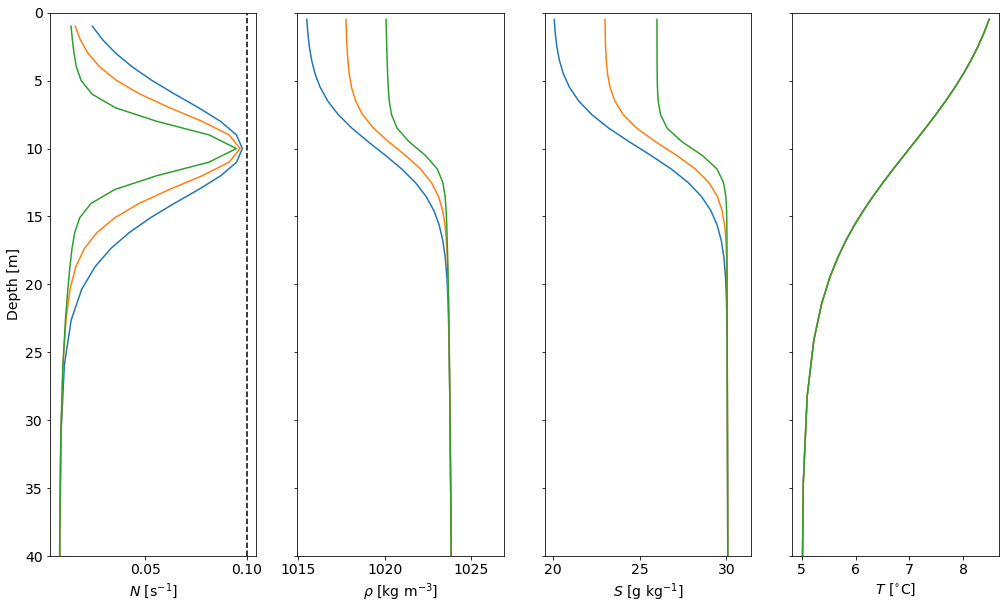

In [40]:
params = {
    'rn_istate_yvary'    : False ,    # Vary initial stratification with y ---------------- [bool]
    'rn_istate_y1'       :  0.0  ,    # Southern y variation point (deepest halocline) ---- [grid Y]
    'rn_istate_y2'       :  0.0  ,    # Northern y variation point (shallowest halocline) - [grid Y]
    'rn_istate_halocline': 10.0  ,    # Halocline depth (constant or maximum) ------------- [m]
    'rn_istate_tsurf'    :  9.0  ,    # Surface temperature ------------------------------- [deg C]
    'rn_istate_tdeep'    :  5.0  ,    # Deep temperature ---------------------------------- [deg C]
    'rn_istate_tdecay'   : -0.2  ,    # T interface decay (controls max gradient) --------- [1/m]
    'rn_istate_tslope'   :  0.0  ,    # T slope below halocline --------------------------- [deg C/m]
    'rn_istate_sdeep'    : 30.0  ,    # Deep salinity ------------------------------------- [g/kg]
    'rn_istate_sslope'   :  0.002,    # S slope below halocline --------------------------- [g/kgm]
}

ylim = [40, 0]
fig, axs = make_plots(ylim=ylim)
axs[0].plot([0.1, 0.1], ylim, 'k--')
for ssurf, sdecay in zip([20, 23, 26], [-0.5, -0.7, -1.2]):
    params.update({
        'rn_istate_ssurf' : ssurf ,   # Surface salinity ---------------------------------- [g/kg]
        'rn_istate_sdecay': sdecay,   # S interface decay (controls max gradient) --------- [1/m]
    })
    plot_profiles(axs, params)

### Constant stratification

Here I vary the surface and deep salinity together and the deep salinity slope. My criteria for these profiles is to create equally spaced $N$ between $0.01$ and $0.25\text{ s}^{-1}$

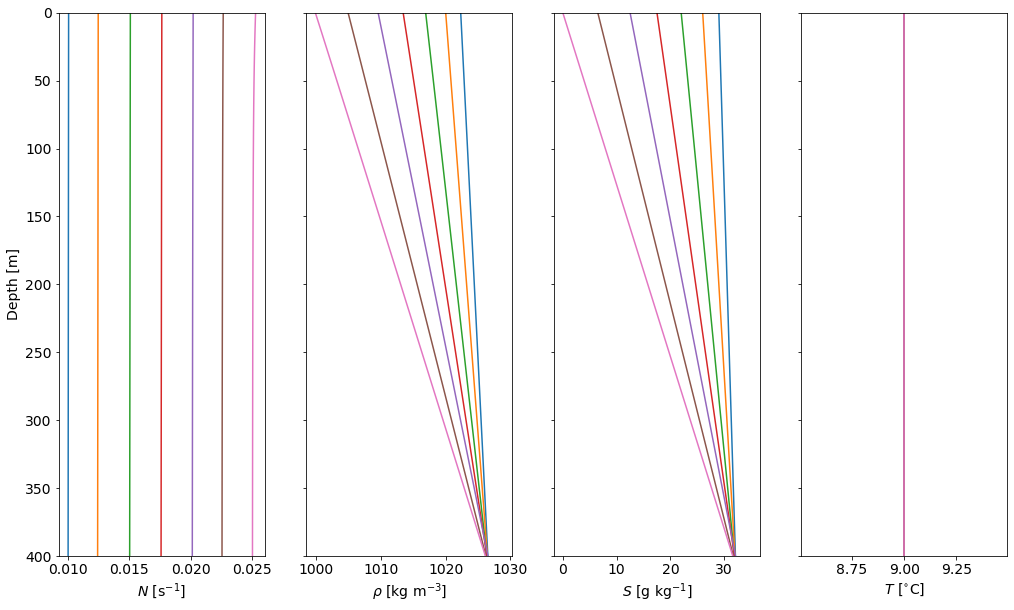

In [188]:
params = {
    'rn_istate_yvary'    : False ,    # Vary initial stratification with y ---------------- [bool]
    'rn_istate_y1'       :  0.0  ,    # Southern y variation point (deepest halocline) ---- [grid Y]
    'rn_istate_y2'       :  0.0  ,    # Northern y variation point (shallowest halocline) - [grid Y]
    'rn_istate_halocline':  0.0  ,    # Halocline depth (constant or maximum) ------------- [m]
    'rn_istate_tsurf'    :  9.0  ,    # Surface temperature ------------------------------- [deg C]
    'rn_istate_tdeep'    :  9.0  ,    # Deep temperature ---------------------------------- [deg C]
    'rn_istate_tdecay'   :  0.0  ,    # T interface decay (controls max gradient) --------- [1/m]
    'rn_istate_tslope'   :  0.0  ,    # T slope below halocline --------------------------- [deg C/m]
    'rn_istate_sdecay'   :  0.0  ,    # S interface decay (controls max gradient) --------- [1/m]
}

ylim = [400, 0]
fig, axs = make_plots(ylim=ylim)
#axs[0].set_xlim([0.02, 0.026])
for ssurf, sslope in zip([29, 26, 22, 17.5, 12.5, 6.5, 0], [0.0077, 0.015, 0.0247, 0.036, 0.049, 0.063, 0.079]):
    params.update({
        'rn_istate_ssurf' : ssurf ,   # Surface salinity ---------------------------------- [g/kg]
        'rn_istate_sdeep' : ssurf ,   # Deep salinity ------------------------------------- [g/kg]
        'rn_istate_sslope': sslope,   # S slope below halocline --------------------------- [g/kgm]
    })
    plot_profiles(axs, params)